In [1]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42)

In [2]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [3]:
circles = pd.DataFrame({'X1':X[:,0],
                        'X2':X[:,1],
                        'label':y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


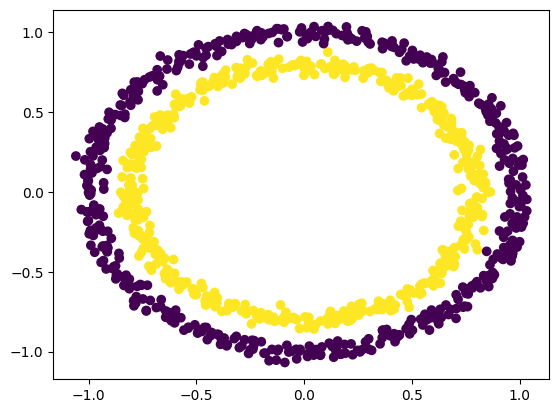

In [4]:
plt.scatter(x = X[:,0],
            y = X[:,1],
            c =y)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42,test_size=0.2)

In [8]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [9]:
X_train, y_train = torch.from_numpy(X_train).type(torch.float).to(device), torch.from_numpy(y_train).type(torch.float).to(device)
X_test , y_test  = torch.from_numpy(X_test).type(torch.float).to(device), torch.from_numpy(y_test).type(torch.float).to(device)

In [10]:
class CircleModelV2(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=32)
    self.layer_2 = nn.Linear(in_features=32, out_features=16)
    self.layer_3 = nn.Linear(in_features=16, out_features=1 )

    self.relu = nn.ReLU()

  def forward(self,x):
    z = self.relu(self.layer_1(x))
    z = self.relu(self.layer_2(z))
    z = self.layer_3(z)
    return z




In [11]:
model = CircleModelV2().to(device)
model

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr=0.1,
                            params= model.parameters())

In [13]:
def accuracy(y_pred,y_true):
  return(torch.eq(y_pred,y_true).sum().item()/len(y_pred))*100

In [14]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  model.train()

  pred_logit = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(pred_logit))

  loss = loss_fn(pred_logit,y_train)

  acc = accuracy(y_pred,y_train)

  optimizer.zero_grad

  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logit = model(X_test).squeeze()
    pred_test = torch.round(torch.sigmoid(test_logit))

    test_loss = loss_fn(test_logit,y_test)
    acc_test = accuracy(pred_test,y_test)

  if epoch %10 ==0:

    print(f"Loss: {loss:0.3f}, Accuracy: {acc:0.03f} | Test Loss: {test_loss:0.3f}, Test Accuracy: {acc_test:0.03f}")



Loss: 0.695, Accuracy: 50.000 | Test Loss: 0.697, Test Accuracy: 50.000
Loss: 0.692, Accuracy: 49.750 | Test Loss: 0.695, Test Accuracy: 50.000
Loss: 0.689, Accuracy: 50.000 | Test Loss: 0.691, Test Accuracy: 55.000
Loss: 0.683, Accuracy: 57.375 | Test Loss: 0.689, Test Accuracy: 51.500
Loss: 0.671, Accuracy: 54.500 | Test Loss: 0.688, Test Accuracy: 49.500
Loss: 0.633, Accuracy: 68.875 | Test Loss: 0.645, Test Accuracy: 68.000
Loss: 0.522, Accuracy: 87.375 | Test Loss: 0.541, Test Accuracy: 85.000
Loss: 0.275, Accuracy: 96.875 | Test Loss: 0.309, Test Accuracy: 93.500
Loss: 0.046, Accuracy: 99.625 | Test Loss: 0.067, Test Accuracy: 98.500
Loss: 0.012, Accuracy: 99.625 | Test Loss: 0.032, Test Accuracy: 97.500


In [15]:
model.eval()
with torch.inference_mode():
  test_l = model(X_test).squeeze()
  test_p = torch.round(torch.sigmoid(test_l))
  test_a = accuracy(test_p, y_test)

In [16]:
test_a

100.0

In [17]:
import requests
from pathlib import Path


if Path('helper_function.py').is_file():
  print("It Already Exists")

else:
  print('Download helper_function.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_function.py', 'wb') as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary


Download helper_function.py


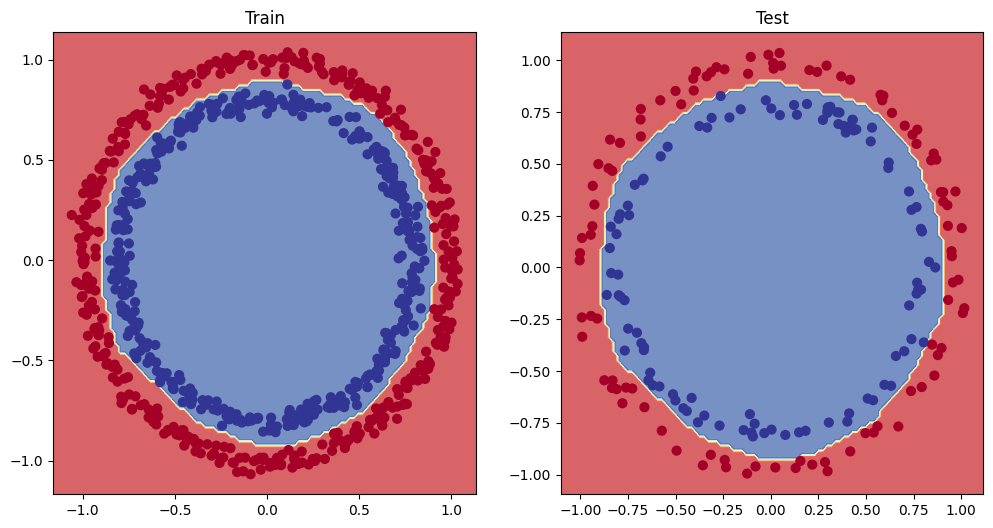

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)